# Resample a DES cluster lensing chain with two parameters

In this example, we will read in a DES Year 1 cluster weak lensing chain with two parameters ($\log_{10}M$,$c$) and build an importance sampler for it. We will then resample it and try to recover (essentially) the exact same chain.

In [1]:
#Import things
import numpy as np
import matplotlib.pyplot as plt
import importance_sampler as isamp
import chainconsumer as CC
import emcee #for doing MCMC
%matplotlib inline

In [2]:
#Plot formatting
plt.rc("font", size=18, family="serif")
plt.rc("text", usetex=True)

In [3]:
#Read in the chain and remove burn-in (which I only know is there for this example)
input_chain = np.loadtxt("DES_RMWL_Mc_chainz0l3.txt")[32*1000:]
lnpost = np.loadtxt("DES_RMWL_Mc_likesz0l3.txt")[32*1000:]
print("chain shape is  ", input_chain.shape)
print("lnpost shape is ", lnpost.shape)

('chain shape is  ', (64000, 2))
('lnpost shape is ', (64000,))


In [4]:
#Pick out training points
N_training = 200
IS = isamp.ImportanceSampler(input_chain, lnpost, scale = 8)
IS.select_training_points(N_training, method="LH")

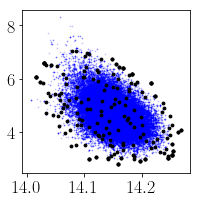

In [5]:
#Visualize the training points selected against the chain
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,3))
plt.subplots_adjust(wspace=0.6)
ax.scatter(input_chain[:,0], input_chain[:,1], c='b', s=0.5, alpha=0.2)

points,_ = IS.get_training_data()
ax.scatter(points[:,0], points[:,1], c='k', s=8)

In [6]:
#Train the GP inside of the sampler
IS.train()

In [7]:
#Set up an MCMC object and run
means = np.mean(input_chain,0)
nwalkers = 32
ndim = len(input_chain[0])

sampler = emcee.EnsembleSampler(nwalkers, ndim, IS.predict)

print("Running first burn-in")
p0 = np.array([means + means*1e-3*np.random.randn(ndim) for i in range(nwalkers)])
p0, lp, _ = sampler.run_mcmc(p0, 1000)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + p0[np.argmax(lp)]*1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()
print("Running production...")
sampler.run_mcmc(p0, 5000);

Running first burn-in
Running second burn-in
Running production...


In [8]:
test_chain = sampler.flatchain
print("Means and stds of input chain: ", np.mean(input_chain, 0), np.std(input_chain, 0))
print("Means and stds of test chain:  ", np.mean(test_chain, 0), np.std(test_chain, 0))

('Means and stds of input chain: ', array([14.14967048,  4.69976706]), array([0.03211171, 0.60469267]))
('Means and stds of test chain:  ', array([14.15078653,  4.67421115]), array([0.03125978, 0.58810503]))


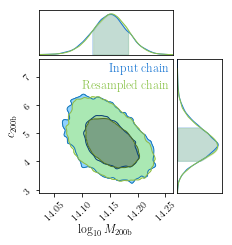

In [9]:
c = CC.ChainConsumer()
c.add_chain(input_chain, parameters=[r"$\log_{10}M_{\rm 200b}$", r"$c_{\rm 200b}$"], name="Input chain")
c.add_chain(test_chain, parameters=[r"$\log_{10}M_{\rm 200b}$", r"$c_{\rm 200b}$"], name="Resampled chain")

fig = c.plotter.plot()
#fig.savefig("cluster_lensing_example.png", dpi=300, bbox_inches="tight")